# Captcha Solver
This captcha solver uses the HOG algorithm for describing letter characteristics, and then the method x for classification.

In [18]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import data, exposure
from skimage.feature import hog
from skimage.transform import resize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

IMG_PATH = 'CAPTCHA-10k/'

## 1. Roughly dividing the letters on the Captcha

Throughout the task, I'll test the functions with a single image to ensure it's working properly.

In [19]:
def get_letters_from_img(img):
    # These widths were set by hand, and tested. Results were satisfactory enough.
    window_widths = [(0, 40), (30, 70), (60, 100), (90, 130), (120, 160), (140, 180)]

    quadrants = []
    for (start_col, end_col) in window_widths:
        quadrant = img[:, start_col:end_col]
        quadrants.append(quadrant)
    quadrants = [resize(q, (128*4, 64*4)) for q in quadrants]

    return quadrants

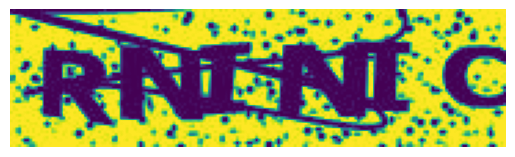

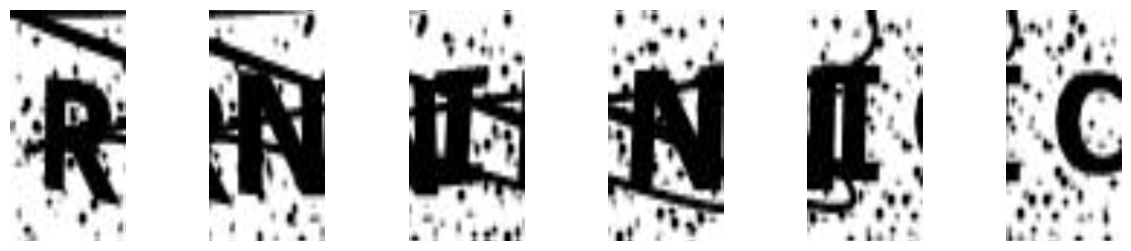

In [20]:
ex_img = cv2.imread(os.path.join(IMG_PATH, 'treinamento/000001.jpg')) 
ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2GRAY)

plt.imshow(ex_img)
plt.axis(False)
plt.show()

ex_letters = get_letters_from_img(ex_img)

fig, axes = plt.subplots(1, len(ex_letters), figsize=(15, 3))
for ax, quadrant in zip(axes, ex_letters):
    ax.imshow(quadrant, cmap='gray')
    ax.axis('off')
plt.show()

## 2. Extracting features using HOG

In [21]:
def hog_on_letters(letters:list) -> list:
    descriptors = []
    
    for l in letters:
        fd = hog(
			l,
			orientations=8,
			pixels_per_cell=(8, 8),
			cells_per_block=(2, 2),
		)
        descriptors.append(fd)
        
    return descriptors

Testing the hog implementation for the first letter of our example:

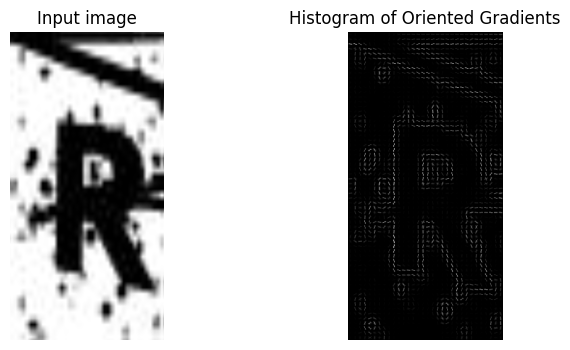

In [22]:
fd, hog_image = hog(
		ex_letters[0],
		orientations=8,
		pixels_per_cell=(8, 8),
		cells_per_block=(2, 2),
		visualize=True,
	)

# Plot HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(ex_letters[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Classification
First, let's take a look at the dimensions of our descriptiors:

In [23]:
ex_descriptors = hog_on_letters(ex_letters)
print(f'Shape of descriptor is {ex_descriptors[0].shape}')

Shape of descriptor is (62496,)


It's important to note that, in theory, each letter is independent from one another. That means our training data will actually consist of single letters.

The code below provides a function that returns descriptors of each letter and their true labels:

In [1]:
def get_descriptors_and_labels(captcha_dir, label_dir):
    descriptors = []
    labels = []

    for img_filename in os.listdir(captcha_dir):
        if img_filename.endswith('.jpg'):
            print(f"Running on {img_filename}")
            img_path = os.path.join(captcha_dir, img_filename)
            img = rgb2gray(imread(img_path))
            
            # Get the letters from the image
            letters = get_letters_from_img(img)
            # Read the corresponding label
            label_path = os.path.join(label_dir, img_filename.replace('.jpg', '.txt'))
            with open(label_path, 'r') as label_file:
                label = label_file.read().strip()
            
            # Ensure we have the same number of letters and label characters
            if len(letters) != len(label):
                print(f'Warning: Mismatch between number of letters and label length for {img_filename}')
                continue
            
            # Computing hog descriptors for each letter
            hog_descriptors = hog_on_letters(letters)
            for descriptor, letter_label in zip(hog_descriptors, label):
                descriptors.append(descriptor)
                labels.append(letter_label)

    # Convert lists to numpy arrays
    np_descriptors = np.array(descriptors)
    np_labels = np.array(labels)

    return np_descriptors, np_labels

Now we'll set up the correct datasets for the classification system, using pickle to save the datasets computed.

In [2]:
# Necessary Directories
training_dir = os.path.join(IMG_PATH, 'treinamento/')
validation_dir = os.path.join(IMG_PATH, 'validacao/')
test_dir = os.path.join(IMG_PATH, 'teste/')
label_dir = os.path.join(IMG_PATH, 'labels10k/')

# Define paths for pickled files
PKL_PATH = 'saved_datasets/'
train_data_path = os.path.join(PKL_PATH, 'train_data.pkl')
validation_data_path = os.path.join(PKL_PATH, 'validation_data.pkl')
test_data_path = os.path.join(PKL_PATH, 'test_data.pkl')

# Function to save data to pickle files
def save_data():
    with open(train_data_path, 'wb') as f:
        pickle.dump((train_X, train_y), f)
    
    with open(validation_data_path, 'wb') as f:
        pickle.dump((validation_X, validation_y), f)
    
    with open(test_data_path, 'wb') as f:
        pickle.dump((test_X, test_y), f)
    
    print("Data has been pickled and saved.")

# Function to load data from pickle files
def load_data():
    global train_X, train_y, validation_X, validation_y, test_X, test_y

    with open(train_data_path, 'rb') as f:
        train_X, train_y = pickle.load(f)
    
    with open(validation_data_path, 'rb') as f:
        validation_X, validation_y = pickle.load(f)
    
    with open(test_data_path, 'rb') as f:
        test_X, test_y = pickle.load(f)

    print("Data has been loaded from pickle files.")

# Check if pickle files exist
if all(os.path.exists(p) for p in [train_data_path, validation_data_path, test_data_path]):
    print("Pickle files found. Loading data...")
    load_data()
else:
    print("Pickle files not found. Generating data...")
    print("Generating training dataset...")
    train_X, train_y = get_descriptors_and_labels(training_dir, label_dir)
    print("Generating validation dataset...")
    validation_X, validation_y = get_descriptors_and_labels(validation_dir, label_dir)
    print("Generating testing dataset...")
    test_X, test_y = get_descriptors_and_labels(test_dir, label_dir)
    save_data()

NameError: name 'os' is not defined

In [ ]:
import os
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /home/cesar/6o_Periodo/ICV/Captcha-Solver


We'll use Random Forest to train the model. It uses several decision trees and its results to prevent overfitting and increase accuracy.

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 30, 50],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the decision tree classifier
dt = RandomForestClassifier(random_state=42)

# Define the scorer
scorer = make_scorer(accuracy_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=scorer, cv=5, return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the results
results = grid_search.cv_results_

# Extract mean train and validation scores for each parameter setting
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']

# Find the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best cross-validation score: {best_score}')

# Plot the training and validation error over different hyperparameter settings
plt.figure(figsize=(14, 7))

# We plot the negative scores to represent the error
plt.plot(-train_scores, label='Training Error')
plt.plot(-val_scores, label='Validation Error')
plt.xlabel('Hyperparameter Setting Index')
plt.ylabel('Negative Accuracy')
plt.title('Training and Validation Error over Hyperparameter Settings')
plt.legend()
plt.show()